## Customer Churn Prediction - Bank

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix, classification_report 
import subprocess
import joblib
# Get multiple outputs in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Reading the DataSet

In [2]:
dc = pd.read_csv("E:/AMotefaker/ABC/Data Analyst/Sales Data Analysis/Customer Churn Prediction - Bank/Churn_Modelling.csv") 

In [3]:
dc.head(5) 

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Exploratory Data Analysis

In [4]:
# Dimension of the dataset
dc.shape

(10000, 14)

In [5]:
# Describe all numerical columns
dc.describe(exclude= ['O'])

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
# Describe all categorical columns
dc.describe(include = ['O'])

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


In [7]:
# Checking number of unique customers in the dataset
dc.shape[0], dc.CustomerId.nunique()

(10000, 10000)

- This means each row corresponds to a customer.

In [8]:
# churn value Distribution
dc["Exited"].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

- The data set is imbalanced from the above result, with a significant chunk of existing customers relative to their churned peers.

#### Group by Surname to see the average churn value:

In [9]:
dc.groupby(['Surname']).agg({'RowNumber':'count', 'Exited':'mean'}
                                  ).reset_index().sort_values(by='RowNumber', ascending=False).head()

,Surname,RowNumber,Exited
2473,Smith,32,0.281250
1689,Martin,29,0.310345
2389,Scott,29,0.103448
2751,Walker,28,0.142857
336,Brown,26,0.192308


#### Group by Geography:

In [10]:
dc.groupby(['Geography']).agg({'RowNumber':'count', 'Exited':'mean'}
                                  ).reset_index().sort_values(by='RowNumber', ascending=False)

,Geography,RowNumber,Exited
0,France,5014,0.161548
1,Germany,2509,0.324432
2,Spain,2477,0.166734


- From what we see above, customers from "Germany" have a higher exiting rate than average.

#### Univariate Plots of Numerical Variables

<AxesSubplot: ylabel='CreditScore'>

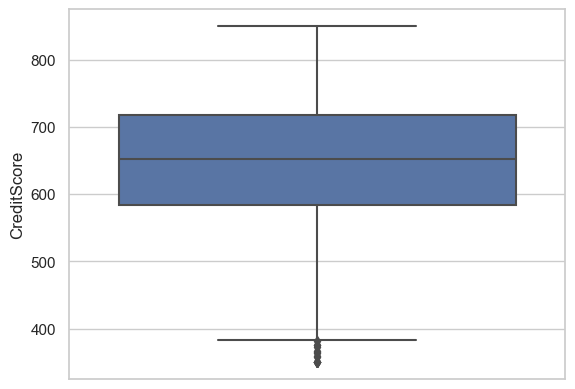

In [11]:
# Plotting CreditScore
sns.set(style="whitegrid")
sns.boxplot(y=dc['CreditScore'])

<AxesSubplot: ylabel='Age'>

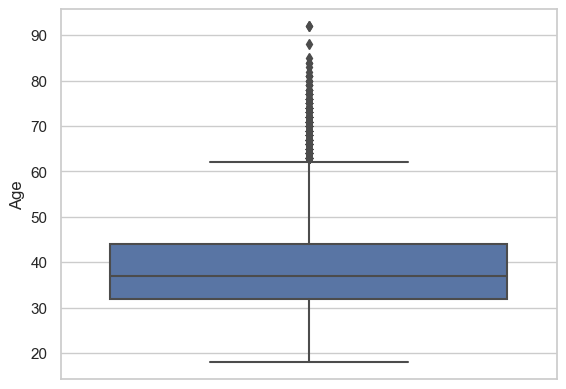

In [12]:
# Plotting Age
sns.boxplot(y=dc['Age'])

<AxesSubplot: ylabel='Tenure'>

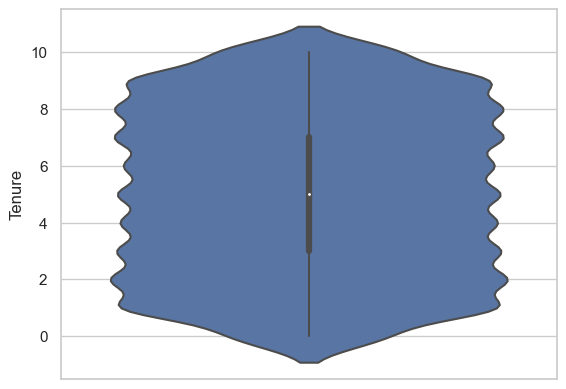

In [13]:
# Tenure violin plot
sns.violinplot(y = dc.Tenure)

<AxesSubplot: ylabel='Balance'>

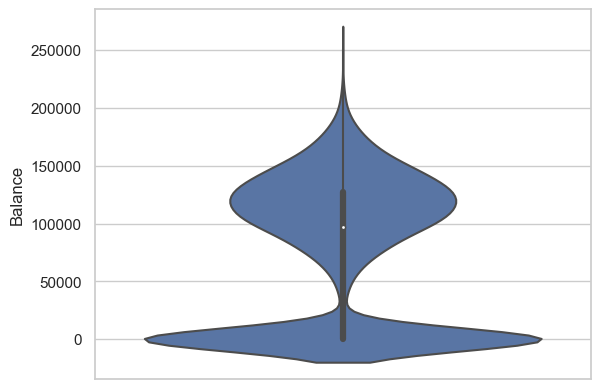

In [14]:
# Balance violin plot
sns.violinplot(y = dc['Balance'])

<AxesSubplot: xlabel='NumOfProducts'>

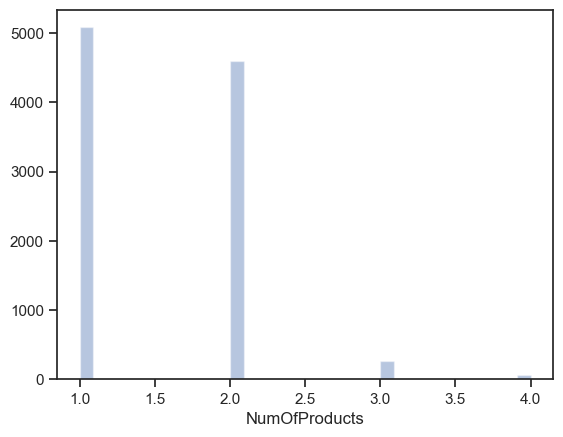

In [15]:
# Plotting a distribution plot of NumOfProducts
sns.set(style = 'ticks')
sns.distplot(dc.NumOfProducts, hist=True, kde=False)

- Most of the customers have 1 or 2 products.

<AxesSubplot: xlabel='EstimatedSalary', ylabel='Density'>

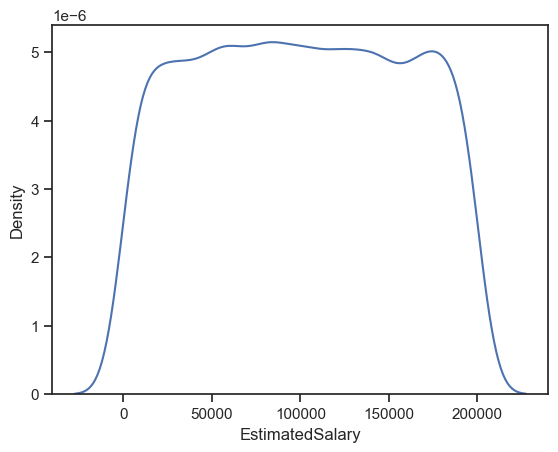

In [16]:
# Kernel density estimation plot for EstimatedSalary
# When dealing with numerical characteristics, one of the most useful statistics to examine is the data distribution.
# we can use Kernel-Density-Estimation plot for that purpose. 
sns.kdeplot(dc.EstimatedSalary)

### Data Preprocessing

Tips:

- We will discard the RowNumber column.
- We will discard CustomerID as well since it doesn't convey any extra info. Each row pertains to a unique customer.
- Features can be segregated into non-essential, numerical, categorical, and target variables based on the above.
- CustomerID is a handy feature based on which we can calculate many user-centric features.

In [17]:
# Separating out different columns into various categories as defined above
target_var = ['Exited']
cols_to_remove = ['RowNumber', 'CustomerId']
# numerical columns
num_feats = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
# categorical columns
cat_feats = ['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

- Tenure and NumOfProducts are ordinal variables. 
- HasCrCard and IsActiveMember are binary categorical variables.

In [18]:
# Separating target variable and removing the non-essential columns
y = dc[target_var].values
dc.drop(cols_to_remove, axis=1, inplace=True)

### Splitting Dataset

- We keep aside a test set to evaluate our model at the very end to estimate our chosen model's performance on unseen data.
- A validation set is also created, which we'll use in our baseline models to evaluate and tune our models.

In [19]:
# Keeping aside a test/holdout set
dc_train_val, dc_test, y_train_val, y_test = train_test_split(dc, y.ravel(), test_size = 0.1, random_state = 42)

# Splitting into train and validation set
dc_train, dc_val, y_train, y_val = train_test_split(dc_train_val, y_train_val, test_size = 0.12, random_state = 42)
dc_train.shape, dc_val.shape, dc_test.shape, y_train.shape, y_val.shape, y_test.shape
np.mean(y_train), np.mean(y_val), np.mean(y_test)

((7920, 12), (1080, 12), (1000, 12), (7920,), (1080,), (1000,))

(0.20303030303030303, 0.22037037037037038, 0.191)

### Categorical Variable Encoding

- 1- Label Encoding: transforms non-numerical labels into numerical ones. It can be used for binary categorical and ordinal variables.

- 2- One-Hot encoding: encodes categorical features as a one-hot numeric array. It can be used for non-ordinal categorical variables with low to mid cardinality (< 5-10 levels)

- 3- Target encoding: the technique of substituting a categorical value with the mean of the target variable is known as target encoding. The target encoder model automatically removes any non-categorical columns. It can be used for Categorical variables with > 10 levels


- HasCrCard and IsActiveMember are already label encoded.
- Gender, a simple label encoding should be acceptable.
- Geography, since there are three levels, one-hot encoding should do the trick.
- Surname, we'll try target/frequency encoding.

### 1- Label Encoding

#### Label Encoding for Binary Variables
- Label encoding on the Gender column.

In [20]:
# label encoding With  the sklearn method
le = LabelEncoder()
# Label encoding of Gender variable
dc_train['Gender'] = le.fit_transform(dc_train['Gender'])
le_gender_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_gender_mapping

{'Female': 0, 'Male': 1}

#### Testing and validation sets

In [21]:
# Encoding Gender feature for validation and test set
dc_val['Gender'] = dc_val.Gender.map(le_gender_mapping)
dc_test['Gender'] = dc_test.Gender.map(le_gender_mapping)

# Filling missing/NaN values created due to new categorical levels
dc_val['Gender'].fillna(-1, inplace=True)
dc_test['Gender'].fillna(-1, inplace=True)

#### Checking the values on all sets

In [22]:
dc_train.Gender.unique(), dc_val.Gender.unique(), dc_test.Gender.unique()

(array([1, 0]), array([1, 0]), array([1, 0]))

### 2- One-Hot encoding

#### One-hot Encoding Categorical Variables

In [23]:
# one-hot encode the Geography column

# With the sklearn method(LabelEncoder())
le_ohe = LabelEncoder()
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse=False)
enc_train = le_ohe.fit_transform(dc_train.Geography).reshape(dc_train.shape[0],1)
ohe_train = ohe.fit_transform(enc_train)
ohe_train

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [24]:
# mapping between classes
le_ohe_geography_mapping = dict(zip(le_ohe.classes_, le_ohe.transform(le_ohe.classes_)))
le_ohe_geography_mapping

{'France': 0, 'Germany': 1, 'Spain': 2}

#### Testing and validation sets

In [25]:
# Encoding Geography feature for validation and test set
enc_val = dc_val.Geography.map(le_ohe_geography_mapping).ravel().reshape(-1,1)
enc_test = dc_test.Geography.map(le_ohe_geography_mapping).ravel().reshape(-1,1)

# Filling missing/NaN values created due to new categorical levels
enc_val[np.isnan(enc_val)] = 9999
enc_test[np.isnan(enc_test)] = 9999
ohe_val = ohe.transform(enc_val)
ohe_test = ohe.transform(enc_test)

- In case there is a country that isn't present in the training set, the resulting vector will simply be [0, 0, 0]:

In [26]:
# Show what happens when a new value is inputted into the OHE 
ohe.transform(np.array([[9999]]))

array([[0., 0., 0.]])

#### Adding the one-hot encoded columns to the data frame and removing the original feature:

In [27]:
cols = ['country_' + str(x) for x in le_ohe_geography_mapping.keys()]
cols

['country_France', 'country_Germany', 'country_Spain']

In [28]:
# Adding to the respective dataframes
dc_train = pd.concat([dc_train.reset_index(), pd.DataFrame(ohe_train, columns = cols)], axis = 1).drop(['index'], axis=1)
dc_val = pd.concat([dc_val.reset_index(), pd.DataFrame(ohe_val, columns = cols)], axis = 1).drop(['index'], axis=1)
dc_test = pd.concat([dc_test.reset_index(), pd.DataFrame(ohe_test, columns = cols)], axis = 1).drop(['index'], axis=1)
print("Training set")
dc_train.head()
print("\n\nValidation set")
dc_val.head()
print("\n\nTest set")
dc_test.head()

Training set


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Yermakova,678,Germany,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0
1,Warlow-Davies,613,France,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0
2,Fu,628,France,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0
3,Shih,513,France,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0
4,Mahmood,639,France,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0




Validation set


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Sun,757,France,1,36,7,144852.06,1,0,0,130861.95,0,1.0,0.0,0.0
1,Russo,552,France,1,29,10,0.00,2,1,0,12186.83,0,1.0,0.0,0.0
2,Munro,619,France,0,30,7,70729.17,1,1,1,160948.87,0,1.0,0.0,0.0
3,Perkins,633,France,1,35,10,0.00,2,1,0,65675.47,0,1.0,0.0,0.0
4,Aliyeva,698,Spain,1,38,10,95010.92,1,1,1,105227.86,0,0.0,0.0,1.0




Test set


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Anderson,596,Germany,1,32,3,96709.07,2,0,0,41788.37,0,0.0,1.0,0.0
1,Herring,623,France,1,43,1,0.00,2,1,1,146379.30,0,1.0,0.0,0.0
2,Amechi,601,Spain,0,44,4,0.00,2,1,0,58561.31,0,0.0,0.0,1.0
3,Liang,506,Germany,1,59,8,119152.10,2,1,1,170679.74,0,0.0,1.0,0.0
4,Chuang,560,Spain,0,27,7,124995.98,1,1,1,114669.79,0,0.0,0.0,1.0


#### Dropping the original Geography column now:

In [29]:
dc_train.drop(['Geography'], axis=1, inplace=True)
dc_val.drop(['Geography'], axis=1, inplace=True)
dc_test.drop(['Geography'], axis=1, inplace=True)

### 3- Target encoding

- Target encoding is generally proper when dealing with categorical variables of high cardinality (high number of levels). 

#### Encode the Surname column (which has 2932 different values!) with the mean of the target variable for that level:

In [30]:
means = dc_train.groupby(['Surname']).Exited.mean()
means.head()
means.tail()

Surname
Abazu       0.00
Abbie       0.00
Abbott      0.25
Abdullah    1.00
Abdulov     0.00
Name: Exited, dtype: float64

Surname
Zubarev     0.0
Zubareva    0.0
Zuev        0.0
Zuyev       0.0
Zuyeva      0.0
Name: Exited, dtype: float64

#### Global mean of Exited column:

In [31]:
global_mean = y_train.mean()
global_mean

0.20303030303030303

In [32]:
# Creating new encoded features for surname - Target (mean) encoding
dc_train['Surname_mean_churn'] = dc_train.Surname.map(means)
dc_train['Surname_mean_churn'].fillna(global_mean, inplace=True)

##### The problem with target encoding is that it might cause "data leakage", as we are considering feedback from the target variable while computing any summary statistic. 

- A solution is to use a modified version: Leave-one-out Target encoding; for a particular data point or row, the mean of the target is calculated by considering all rows in the same definite level except itself. It mitigates data leakage and overfitting to some extent.

#### Calculating the frequency of each Surname:

In [33]:
freqs = dc_train.groupby(['Surname']).size()
freqs.head()

Surname
Abazu       2
Abbie       1
Abbott      4
Abdullah    1
Abdulov     1
dtype: int64

#### Create frequency encoding - Number of instances of each category in the data:

In [34]:
dc_train['Surname_freq'] = dc_train.Surname.map(freqs)
dc_train['Surname_freq'].fillna(0, inplace=True)

#### Creating Leave-one-out target encoding for Surname:

In [35]:
dc_train['Surname_enc'] = ((dc_train.Surname_freq * dc_train.Surname_mean_churn) - dc_train.Exited)/(dc_train.Surname_freq - 1)
# Fill NaNs occuring due to category frequency being 1 or less
dc_train['Surname_enc'].fillna((((dc_train.shape[0] * global_mean) - dc_train.Exited) / (dc_train.shape[0] - 1)), inplace=True)
dc_train.head(5)

,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_mean_churn,Surname_freq,Surname_enc
0,Yermakova,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0,0.000000,4,0.000000
1,Warlow-Davies,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0,0.000000,2,0.000000
2,Fu,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0,0.200000,10,0.222222
3,Shih,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0,0.285714,21,0.300000
4,Mahmood,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0,0.333333,3,0.500000


#### On the validation and testing set, we'll apply the regular target encoding mapping as obtained from the training set:

In [36]:
# Replacing by category means and new category levels by global mean
dc_val['Surname_enc'] = dc_val.Surname.map(means)
dc_val['Surname_enc'].fillna(global_mean, inplace=True)
dc_test['Surname_enc'] = dc_test.Surname.map(means)
dc_test['Surname_enc'].fillna(global_mean, inplace=True)
# Show that using LOO Target encoding decorrelates features
dc_train[['Surname_mean_churn', 'Surname_enc', 'Exited']].corr()

,Surname_mean_churn,Surname_enc,Exited
Surname_mean_churn,1.000000,0.54823,0.562677
Surname_enc,0.548230,1.00000,-0.026440
Exited,0.562677,-0.02644,1.000000


- As you can see, "Surname_enc" isn't highly correlated with "Exited" as "Surname_mean_churn", so Leave-one-out is effective here.

#### Deleting the Surname and other redundant columns across the three datasets:

In [37]:
dc_train.drop(['Surname_mean_churn'], axis=1, inplace=True)
dc_train.drop(['Surname_freq'], axis=1, inplace=True)
dc_train.drop(['Surname'], axis=1, inplace=True)
dc_val.drop(['Surname'], axis=1, inplace=True)
dc_test.drop(['Surname'], axis=1, inplace=True)
dc_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc
0,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0,0.000000
1,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0,0.000000
2,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0,0.222222
3,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0,0.300000
4,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0,0.500000


#### Summary:

- Use label encoding and one-hot encoding on the training set and then save the mapping and apply it to the test set. For missing values, use 0, -1 etc.

- Target/Frequency encoding: Create a mapping between each level and a statistical measure (mean, median, sum, etc.) of the target from the training dataset. For the new categorical levels, impute the missing values suitably (can be 0, -1, or mean/mode/median).

- Leave-one-out or Cross-fold Target encoding avoids data leakage and helps generalize the model.

### Bivariate Analysis

#### Checking the linear correlation between individual features and the target variable:

In [38]:
corr = dc_train.corr()

<AxesSubplot: >

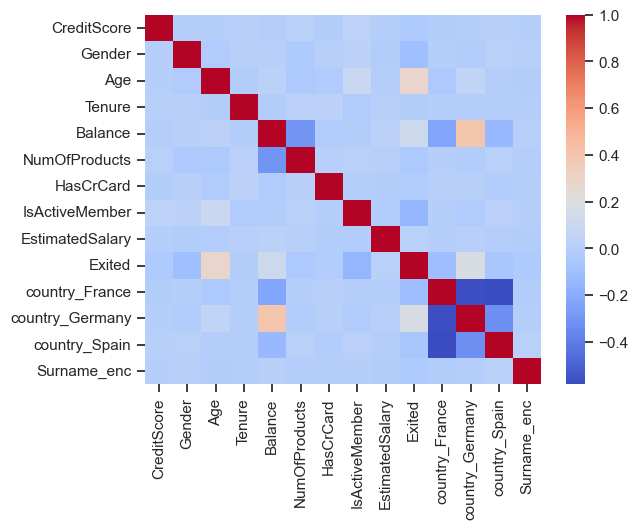

In [39]:
# Drawing a heatmap
sns.heatmap(corr, cmap = 'coolwarm')

- None of the features are highly correlated with the target variable. 
  But some of them have slight linear associations with the target variable:

    - Continuous features: Age, Balance.
    - Categorical variables: Gender, IsActiveMember, country_Germany, country_France.

#### Individual features versus their distribution across target variable values, for "Age" column:

<AxesSubplot: xlabel='Exited', ylabel='Age'>

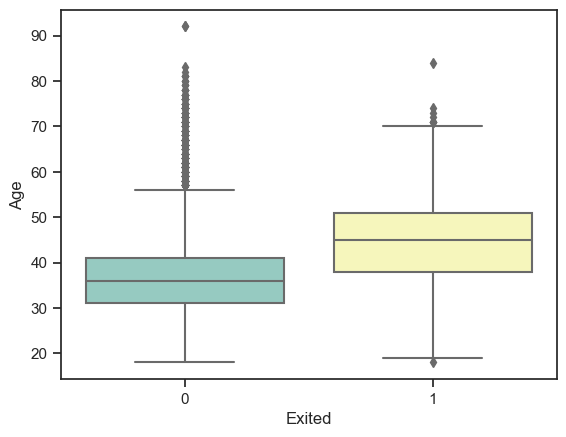

In [40]:
sns.boxplot(x="Exited", y="Age", data=dc_train, palette="Set3")

- Tips:
    - There is an outside point at 90 for class 0 and 83 for class 1.
    - The Median is around 35 for class 0 and 45 for class 1.
    - The lower adjacent value is a bit less than 20 for both classes.
    - The upper adjoining value is around 55 for class 0 and more than 70 for class 1.

####  Violin plot for the "Balance":

<AxesSubplot: xlabel='Exited', ylabel='Balance'>

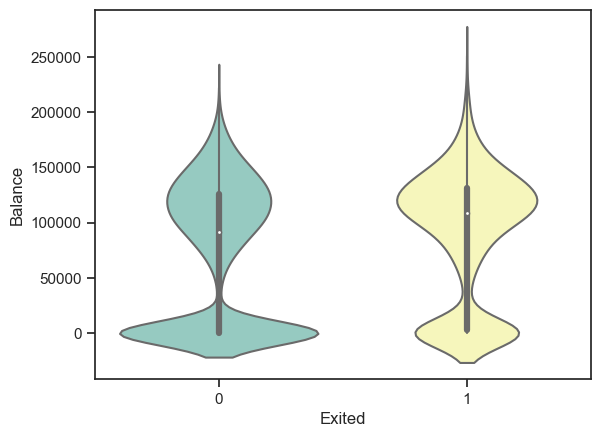

In [41]:
sns.violinplot(x="Exited", y="Balance", data=dc_train, palette="Set3")

- We see a high probability of observation at 125000 (balance) and a peak at 0 (balance) for class 0.

#### Checking the association of categorical features with the target variable:

In [42]:
cat_vars_bv = ['Gender', 'IsActiveMember', 'country_Germany', 'country_France']

for col in cat_vars_bv:
    dc_train.groupby([col]).Exited.mean()
    print()

Gender
0    0.248191
1    0.165511
Name: Exited, dtype: float64

IsActiveMember
0    0.266285
1    0.143557
Name: Exited, dtype: float64

country_Germany
0.0    0.163091
1.0    0.324974
Name: Exited, dtype: float64

country_France
0.0    0.245877
1.0    0.160593
Name: Exited, dtype: float64

- From the above results, we can observe that the mean of the churned customer across "Germany" is higher than the others.

In [43]:
# Computed mean on churned or non chuned custmers group by number of product on training data
col = 'NumOfProducts'
dc_train.groupby([col]).Exited.mean()
# unique "NumOfProducts" on training data
dc_train[col].value_counts()

NumOfProducts
1    0.273428
2    0.076881
3    0.825112
4    1.000000
Name: Exited, dtype: float64

1    4023
2    3629
3     223
4      45
Name: NumOfProducts, dtype: int64

- All customers with four products have churned.
- About 82.5% of customers with three products have churned.

#### Creating some new features based on simple interactions between the existing features:

In [44]:
eps = 1e-6

dc_train['bal_per_product'] = dc_train.Balance/(dc_train.NumOfProducts + eps)
dc_train['bal_by_est_salary'] = dc_train.Balance/(dc_train.EstimatedSalary + eps)
dc_train['tenure_age_ratio'] = dc_train.Tenure/(dc_train.Age + eps)
dc_train['age_surname_mean_churn'] = np.sqrt(dc_train.Age) * dc_train.Surname_enc

In [45]:
new_cols = ['bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio', 'age_surname_mean_churn']
# Ensuring that the new column doesn't have any missing values
dc_train[new_cols].isnull().sum()

bal_per_product           0
bal_by_est_salary         0
tenure_age_ratio          0
age_surname_mean_churn    0
dtype: int64

<AxesSubplot: >

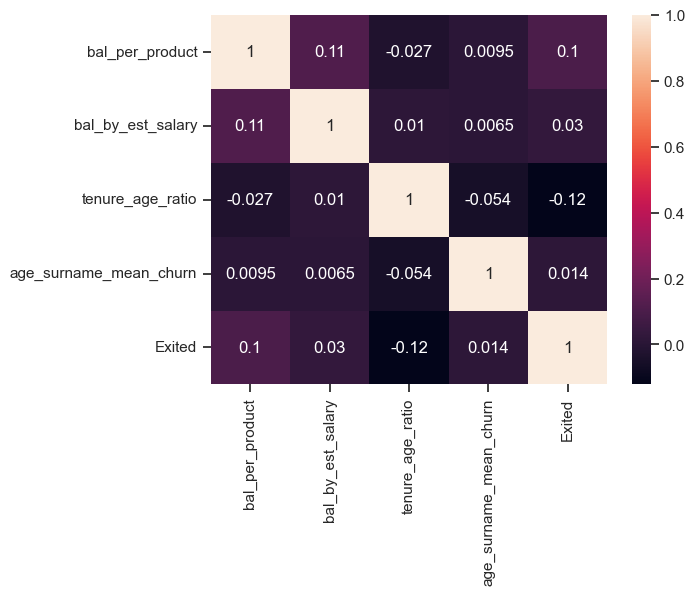

In [46]:
# Linear association of new columns with target variables to judge importance
sns.heatmap(dc_train[new_cols + ['Exited']].corr(), annot=True)

- Out of the new features, ones with slight linear association/correlation are "bal_per_product" and "tenure_age_ratio".

#### Creating them on the validation and testing sets:

In [47]:
dc_val['bal_per_product'] = dc_val.Balance/(dc_val.NumOfProducts + eps)
dc_val['bal_by_est_salary'] = dc_val.Balance/(dc_val.EstimatedSalary + eps)
dc_val['tenure_age_ratio'] = dc_val.Tenure/(dc_val.Age + eps)
dc_val['age_surname_mean_churn'] = np.sqrt(dc_val.Age) * dc_val.Surname_enc
dc_test['bal_per_product'] = dc_test.Balance/(dc_test.NumOfProducts + eps)
dc_test['bal_by_est_salary'] = dc_test.Balance/(dc_test.EstimatedSalary + eps)
dc_test['tenure_age_ratio'] = dc_test.Tenure/(dc_test.Age + eps)
dc_test['age_surname_mean_churn'] = np.sqrt(dc_test.Age) * dc_test.Surname_enc

### Feature Scaling and Normalization

#### Scale the continuous columns with the "StandardScaler":

In [48]:
# initialize the standard scaler
sc = StandardScaler()
cont_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Surname_enc', 'bal_per_product'
             , 'bal_by_est_salary', 'tenure_age_ratio', 'age_surname_mean_churn']
cat_vars = ['Gender', 'HasCrCard', 'IsActiveMember', 'country_France', 'country_Germany', 'country_Spain']
# Scaling only continuous columns
cols_to_scale = cont_vars
sc_X_train = sc.fit_transform(dc_train[cols_to_scale])
# Converting from array to dataframe and naming the respective features/columns
sc_X_train = pd.DataFrame(data=sc_X_train, columns=cols_to_scale)
sc_X_train.shape
sc_X_train.head()

(7920, 11)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn
0,0.284761,-0.274383,-1.389130,0.670778,0.804059,-1.254732,-1.079210,-0.062389,0.095448,-1.232035,-1.062507
1,-0.389351,-1.128482,-0.004763,0.787860,-0.912423,1.731950,-1.079210,1.104840,-0.118834,0.525547,-1.062507
2,-0.233786,0.579716,1.379604,-1.218873,0.804059,-0.048751,0.094549,-1.100925,-0.155854,0.690966,0.193191
3,-1.426446,-0.843782,-0.004763,-1.218873,0.804059,1.094838,0.505364,-1.100925,-0.155854,0.318773,0.321611
4,-0.119706,-1.602981,-0.350855,-1.218873,0.804059,-1.244806,1.561746,-1.100925,-0.155854,0.487952,0.912973


In [49]:
# Scaling validation and test sets by transforming the mapping obtained through the training set
sc_X_val = sc.transform(dc_val[cols_to_scale])
sc_X_test = sc.transform(dc_test[cols_to_scale])
# Converting val and test arrays to dataframes for re-usability
sc_X_val = pd.DataFrame(data=sc_X_val, columns=cols_to_scale)
sc_X_test = pd.DataFrame(data=sc_X_test, columns=cols_to_scale)

- Feature scaling is essential for algorithms like Logistic Regression and SVM. 
- Feature scaling is not necessarily crucial for tree-based models such as decision trees.

### Feature Selection using RFE

- We can perform feature selection by eliminating features from the training dataset through Recursive Feature Elimination (RFE).

- Features shortlisted through EDA/manual inspection and bivariate analysis: 
    - Age, Gender, Balance, NumOfProducts, IsActiveMember, the three Geography variables, bal_per_product, tenure_age_ratio.

-  let's see whether feature selection and elimination through RFE give us the same list of features, other extra features, or a lesser number of features. 

#### To begin with, we'll feed all features to the RFE and LogReg model:

In [50]:
# Creating feature-set and target for RFE model
y = dc_train['Exited'].values
X = dc_train[cat_vars + cont_vars]
X.columns = cat_vars + cont_vars
X.columns

Index(['Gender', 'HasCrCard', 'IsActiveMember', 'country_France',
       'country_Germany', 'country_Spain', 'CreditScore', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'EstimatedSalary', 'Surname_enc',
       'bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio',
       'age_surname_mean_churn'],
      dtype='object')

#### We want to select ten features (you can change that if you wish to), so we set n_features_to_select as 10:

In [51]:
# for logistics regression
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=10) 
rfe = rfe.fit(X.values, y) 
# mask of selected features
print(rfe.support_)
# The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature 
print(rfe.ranking_)

[ True  True  True  True  True  True False  True False False  True False
  True False False  True False]
[1 1 1 1 1 1 4 1 3 6 1 8 1 7 5 1 2]


- Printed the selected features as well as the ranking of the feature by importance.

In [52]:
# Logistic regression (linear)
mask = rfe.support_.tolist()
selected_feats = [b for a,b in zip(mask, X.columns) if a]
selected_feats

['Gender',
 'HasCrCard',
 'IsActiveMember',
 'country_France',
 'country_Germany',
 'country_Spain',
 'Age',
 'NumOfProducts',
 'Surname_enc',
 'tenure_age_ratio']

- Features that were chosen for logistic regression.

In [53]:
rfe_dt = RFE(estimator=DecisionTreeClassifier(max_depth = 4, criterion = 'entropy'), n_features_to_select=10) 
rfe_dt = rfe_dt.fit(X.values, y)  
mask = rfe_dt.support_.tolist()
selected_feats_dt = [b for a,b in zip(mask, X.columns) if a]
selected_feats_dt

['IsActiveMember',
 'country_Germany',
 'Age',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'bal_per_product',
 'bal_by_est_salary',
 'tenure_age_ratio',
 'age_surname_mean_churn']

- Features that were chosen for the decision tree model.

### Baseline Model 1: Logistic Regression

#### Train the linear models on the features selected with RFE:

In [54]:
selected_cat_vars = [x for x in selected_feats if x in cat_vars]
selected_cont_vars = [x for x in selected_feats if x in cont_vars]
# Using categorical features and scaled numerical features
X_train = np.concatenate((dc_train[selected_cat_vars].values, sc_X_train[selected_cont_vars].values), axis=1)
X_val = np.concatenate((dc_val[selected_cat_vars].values, sc_X_val[selected_cont_vars].values), axis=1)
X_test = np.concatenate((dc_test[selected_cat_vars].values, sc_X_test[selected_cont_vars].values), axis=1)
# print the shapes
X_train.shape, X_val.shape, X_test.shape

((7920, 10), (1080, 10), (1000, 10))

- During the training phase, the weight differential will affect the classification of the classes.

#### The overall goal is to penalize the minority class for misclassification by increasing class weight while decreasing weight for the majority class:

In [55]:
# Obtaining class weights based on the class samples imbalance ratio
_, num_samples = np.unique(y_train, return_counts=True)
weights = np.max(num_samples)/num_samples
# Define weight dictionnary
weights_dict = dict()
class_labels = [0,1]
# Weights associated with classes
for a,b in zip(class_labels,weights):
    weights_dict[a] = b

weights_dict

{0: 1.0, 1: 3.925373134328358}

#### Retrain with class_weight:

In [56]:
# Defining model
lr = LogisticRegression(C=1.0, penalty='l2', class_weight=weights_dict, n_jobs=-1)
# train
lr.fit(X_train, y_train)
print(f'Confusion Matrix: \n{confusion_matrix(y_val, lr.predict(X_val))}')
print(f'Area Under Curve: {roc_auc_score(y_val, lr.predict(X_val))}')
print(f'Recall score: {recall_score(y_val,lr.predict(X_val))}')
print(f'Classification report: \n{classification_report(y_val,lr.predict(X_val))}')

LogisticRegression(class_weight={0: 1.0, 1: 3.925373134328358}, n_jobs=-1)

Confusion Matrix: 
[[590 252]
 [ 71 167]]
Area Under Curve: 0.7011966306712709
Recall score: 0.7016806722689075
Classification report: 
              precision    recall  f1-score   support

           0       0.89      0.70      0.79       842
           1       0.40      0.70      0.51       238

    accuracy                           0.70      1080
   macro avg       0.65      0.70      0.65      1080
weighted avg       0.78      0.70      0.72      1080



### Baseline Model 2: Support Vector Machines(SVM)

#### Train an SVC:

In [57]:
svm = SVC(C=1.0, kernel="linear", class_weight=weights_dict)
svm.fit(X_train, y_train)

SVC(class_weight={0: 1.0, 1: 3.925373134328358}, kernel='linear')

In [58]:
# Validation metrics
print(f'Confusion Matrix: {confusion_matrix(y_val, lr.predict(X_val))}')
print(f'Area Under Curve: {roc_auc_score(y_val, lr.predict(X_val))}')
print(f'Recall score: {recall_score(y_val,lr.predict(X_val))}')
print(f'Classification report: \n{classification_report(y_val,lr.predict(X_val))}')

Confusion Matrix: [[590 252]
 [ 71 167]]
Area Under Curve: 0.7011966306712709
Recall score: 0.7016806722689075
Classification report: 
              precision    recall  f1-score   support

           0       0.89      0.70      0.79       842
           1       0.40      0.70      0.51       238

    accuracy                           0.70      1080
   macro avg       0.65      0.70      0.65      1080
weighted avg       0.78      0.70      0.72      1080



### Plotting Decision Boundaries of Linear Models

- To plot the decision boundaries of classification models in a 2-D space, we first need to train our models in a 2D space. 
- The best option is to use our existing data (with > 2 features) and apply dimensionality reduction techniques (like PCA) to it and then train our models on this data with a reduced number of features.

##### - We will create an image in Meshgrid in which each pixel represents a grid cell in the 2D feature space. 
##### - Over the 2D feature space, the image creates a grid. The classifier is used to classify the image's pixels, assigning a class label to each grid cell. 
##### - The identified image is then utilized as the backdrop for a scatter plot with data points from each class.

In [59]:
pca = PCA(n_components=2)
# Transforming the dataset using PCA
X_pca = pca.fit_transform(X_train)
y = y_train
X_pca.shape, y.shape

((7920, 2), (7920,))

LogisticRegression(class_weight={0: 1.0, 1: 3.925373134328358}, n_jobs=-1)

SVC(class_weight={0: 1.0, 1: 3.925373134328358}, kernel='linear')

<AxesSubplot: >

Text(0.5, 1.0, 'Linear models - LogReg and SVM')

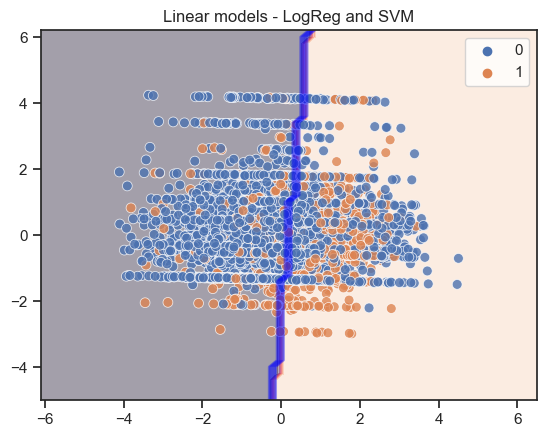

In [65]:
# min and max values 
xmin, xmax = X_pca[:, 0].min() - 2, X_pca[:, 0].max() + 2
ymin, ymax = X_pca[:, 1].min() - 2, X_pca[:, 1].max() + 2
# Creating a mesh region where the boundary will be plotted
xx, yy = np.meshgrid(np.arange(xmin, xmax, 0.2),
                     np.arange(ymin, ymax, 0.2))
# Fitting LR model on 2 features
lr.fit(X_pca, y)
# Fitting SVM model on 2 features
svm.fit(X_pca, y)
# Plotting decision boundary for LR
z1 = lr.predict(np.c_[xx.ravel(), yy.ravel()])
z1 = z1.reshape(xx.shape)
# Plotting decision boundary for SVM
z2 = svm.predict(np.c_[xx.ravel(), yy.ravel()])
z2 = z2.reshape(xx.shape)
# Displaying the result
plt.contourf(xx, yy, z1, alpha=0.4) # LR
plt.contour(xx, yy, z2, alpha=0.4, colors='blue') # SVM
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_train, s=50, alpha=0.8)
plt.title('Linear models - LogReg and SVM')

#### Tips:
- Logistic regression estimator uses a linear separator for decision boundary.
- The Support Vector Machine finds a hyperplane with the maximum margin that divides the feature space into two classes.
- Decision Dense sampling with a mesh grid may be used to illustrate decision boundary. However, the boundaries will seem erroneous if the grid resolution is insufficient. Mesh grid aims to generate a rectangular grid from an array of x values and an array of y values.

### Baseline Model 3 (Non-linear): Decision Tree Classifier

- Decision Trees are among the easiest algorithms to grasp, and their rationale is straightforward to explain.

In [66]:
# Features selected from the RFE process
selected_feats_dt

['IsActiveMember',
 'country_Germany',
 'Age',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'bal_per_product',
 'bal_by_est_salary',
 'tenure_age_ratio',
 'age_surname_mean_churn']

In [67]:
# Re-defining X_train and X_val to consider original unscaled continuous features. y_train and y_val remain unaffected
X_train = dc_train[selected_feats_dt].values
X_val = dc_val[selected_feats_dt].values
# Decision tree classiier model
clf = DecisionTreeClassifier(criterion='entropy', class_weight=weights_dict, max_depth=4, max_features=None
                            , min_samples_split=25, min_samples_leaf=15)
# Fit the model
clf.fit(X_train, y_train)
# Checking the importance of different features of the model
pd.DataFrame({'features': selected_feats,
              'importance': clf.feature_importances_
             }).sort_values(by='importance', ascending=False)

DecisionTreeClassifier(class_weight={0: 1.0, 1: 3.925373134328358},
                       criterion='entropy', max_depth=4, min_samples_leaf=15,
                       min_samples_split=25)

,features,importance
2,IsActiveMember,0.476841
4,country_Germany,0.351863
0,Gender,0.096402
6,Age,0.032268
1,HasCrCard,0.028361
7,NumOfProducts,0.010400
5,country_Spain,0.003865
3,country_France,0.000000
8,Surname_enc,0.000000
9,tenure_age_ratio,0.000000


- IsActiveMember, country_Germany, Gender are the most important features for a decision tree.

#### Evaluating the model on training and validation dataset:

In [69]:
# Validation metrics
print(f'Confusion Matrix: {confusion_matrix(y_val, clf.predict(X_val))}')
print(f'Area Under Curve: {roc_auc_score(y_val, clf.predict(X_val))}')
print(f'Recall score: {recall_score(y_val,clf.predict(X_val))}')
print(f'Classification report: \n{classification_report(y_val,clf.predict(X_val))}')

Confusion Matrix: [[633 209]
 [ 61 177]]
Area Under Curve: 0.7477394758378411
Recall score: 0.7436974789915967
Classification report: 
              precision    recall  f1-score   support

           0       0.91      0.75      0.82       842
           1       0.46      0.74      0.57       238

    accuracy                           0.75      1080
   macro avg       0.69      0.75      0.70      1080
weighted avg       0.81      0.75      0.77      1080



- We got better metrics here, 0.7 as a macro average of F1-score and 0.77 as a weighted average.

#### Performing decision tree rule engine visualization, which is a helpful tool to understand your model:

In [99]:
# Decision tree Classifier
clf = DecisionTreeClassifier(criterion='entropy', class_weight=weights_dict, 
                            max_depth=3, max_features=None,
                            min_samples_split=25, min_samples_leaf=15)
# We fit the model
clf.fit(X_train, y_train)
# Export now as a dot file
dot_data = export_graphviz(clf, out_file='tree.dot',
                          feature_names=selected_feats_dt,
                          class_names=['Did not churn', 'Churned'],
                          rounded=True, proportion=False,
                          precision=2, filled=True)
# # Convert to png using system command (requires Graphviz installation)
# subprocess.run(['dot', '-Tpng','tree.dot', '-o', 'tree.png', '-Gdpi=600'], shell=True)
# # Display the rule-set of a single tree
# from IPython.display import Image
# Image(filename='tree.png')

DecisionTreeClassifier(class_weight={0: 1.0, 1: 3.925373134328358},
                       criterion='entropy', max_depth=3, min_samples_leaf=15,
                       min_samples_split=25)

#### In the graph above:

    - We create and train a model.
    - The export_graphviz() function creates a GraphViz representation of the decision tree.
    - Using a system command, we can convert the dot to png with the subprocess.run() method command.
    - We visualize the image by calling the function Image(filename = 'tree.png').
    - Entropy is a measure of the unpredictability of the information being processed. The greater the entropy, the more       difficult it is to make inferences from the information.
    - This decision tree reveals that the model is a series of logical questions and answers similar to what humans would develop when making predictions.